In [1]:
import pandas as pd
import plotly.express as px

In [2]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# set up plotly defaults
pio.renderers.default = "plotly_mimetype+svg"
pio.templates["book"] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350,
        height=250,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        title=dict(x=0.5, xanchor="center"),
    )
)
pio.templates.default = "simple_white+book"

# Joining

Data scientists very frequently want to *join* two or more dataframes together
in order to connect data values across dataframes. For instance, an online
bookstore might have one dataframe with the books each user has ordered and a
second dataframe with the genres of each book. By joining the two dataframes
together, the data scientist can see what genres each user prefers.

We'll continue looking at the baby names data. We'll use joins to check some
trends mentioned in the New York Times article about baby names
{cite}`williamsLilith2021`. The article talks about how certain categories of
names have become more or less popular over time. For instance, it mentions
that mythological names like Julius and Cassius have become popular, while baby
boomer names like Susan and Debbie have become less popular. How has the
popularity of these categories changed over time?

We've taken the names and categories in the NYT article and put them in a small
dataframe:

In [3]:
nyt = pd.read_csv('data/nyt_names.csv')
nyt

,nyt_name,category
0,Lucifer,forbidden
1,Lilith,forbidden
2,Danger,forbidden
3,Amen,evangelical
4,Savior,evangelical
5,Canaan,evangelical
6,Creed,evangelical
7,Saint,evangelical
8,Susan,boomer
9,Debbie,boomer


To see how popular the categories of names are, we join the `nyt` dataframe
with the `baby` dataframe to get the name counts from `baby`.

In [4]:
baby = pd.read_csv("data/babynames.csv")
baby

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
3,Elijah,M,13034,2020
4,William,M,12541,2020
...,...,...,...,...
2020717,Ula,F,5,1880
2020718,Vannie,F,5,1880
2020719,Verona,F,5,1880
2020720,Vertie,F,5,1880


Imagine going down each row in `baby` and asking, is this name in the `nyt`
table? If so, then add the value in the `category` column to the row. That's
the basic idea behind a join. Let's look at a few simpler examples first.

## Inner Joins

We'll make smaller versions of the `baby` and `nyt` tables so it's easier to
see what happens when we join tables together.

In [5]:
nyt_small = nyt.iloc[[11,12,14]].reset_index(drop=True)
nyt_small

,nyt_name,category
0,Karen,boomer
1,Julius,mythology
2,Freya,mythology


In [6]:
names_to_keep = ['Julius', 'Karen', 'Noah']
baby_small = (baby
              .query("Year == 2020 and Name in @names_to_keep")
              .reset_index(drop=True)
                    )
baby_small

,Name,Sex,Count,Year
0,Noah,M,18252,2020
1,Julius,M,960,2020
2,Karen,M,6,2020
3,Karen,F,325,2020
4,Noah,F,305,2020


To join tables in `pandas`, we'll use the `.merge()` method:

In [7]:
baby_small.merge(nyt_small,
                 left_on = 'Name',          #column in left table to match
                 right_on = 'nyt_name'      #column in right table to match
                )

,Name,Sex,Count,Year,nyt_name,category
0,Julius,M,960,2020,Julius,mythology
1,Karen,M,6,2020,Karen,boomer
2,Karen,F,325,2020,Karen,boomer


Notice that the new table has the columns of both `baby_small` and `nyt_small`
tables. The rows with the name Noah are gone. And the remaining rows have their
matching `category` from `nyt_small`.

When we join two tables together, we tell `pandas` the column(s) from each
table that we want to use to join (the `left_on` and `right_on` arguments).
`pandas` matches rows together when the values in the joining columns match, as
shown in {numref}`fig:inner-join`.

```{figure} figures/inner-join.svg
---
name: fig:inner-join
alt: inner-join
---
To join, `pandas` matches rows using the values in the `Name` and `nyt_name`
columns. For inner joins (the default), rows that don't have matching values
are dropped.
```

By default, `pandas` does an *inner join*. If either table has rows that don't
have matches in the other table, `pandas` drops those rows from the result. In
this case, the Noah rows in `baby_small` don't have matches in
`nyt_small`, so they are dropped. Also, the Freya row in `nyt_small`
doesn't have matches in `baby_small`, so it's dropped as well. Only the
rows with a match in both tables stay in the final result.

## Left, Right, and Outer Joins


We will sometimes want to keep rows without a match instead of dropping them entirely. There are other types of joins---left, right, and outer---that keep rows even when they don't have a match.

In a left join, rows in the left table without a match are kept in the final result, as shown in {numref}fig:left-join.

```{figure} figures/left-join.svg
---
name: fig:left-join
alt: left-join
---
In a left join, rows in the left table that don't have matching values are kept. 
```

To do a left join in `pandas`, use `how='left'` in the call to `.merge()`:

In [8]:
baby_small.merge(nyt_small,
                 left_on='Name',        
                 right_on='nyt_name',
                 how='left')           # left join instead of inner

,Name,Sex,Count,Year,nyt_name,category
0,Noah,M,18252,2020,NaN,NaN
1,Julius,M,960,2020,Julius,mythology
2,Karen,M,6,2020,Karen,boomer
3,Karen,F,325,2020,Karen,boomer
4,Noah,F,305,2020,NaN,NaN


Notice that the Noah rows are kept in the final table. Since those rows didn't
have a match in the `nyt_small` dataframe, the join leaves `NaN` values in the
`nyt_name` and `category` columns. Also, notice that the Freya row in
`nyt_small` is still dropped.

A *right join* works similarly to the left join, except that non-matching rows
in the right table are kept instead of the left table:

In [9]:
baby_small.merge(nyt_small,
                 left_on='Name',
                 right_on='nyt_name',
                 how='right')          #Right join instead of inner

,Name,Sex,Count,Year,nyt_name,category
0,Karen,M,6.0,2020.0,Karen,boomer
1,Karen,F,325.0,2020.0,Karen,boomer
2,Julius,M,960.0,2020.0,Julius,mythology
3,NaN,NaN,NaN,NaN,Freya,mythology


Finally, an *outer join* keeps rows from both tables even when they don't have
a match. 

In [10]:
baby_small.merge(nyt_small,
                 left_on='Name',
                 right_on='nyt_name',
                 how='outer')         #Outer join

,Name,Sex,Count,Year,nyt_name,category
0,Noah,M,18252.0,2020.0,NaN,NaN
1,Noah,F,305.0,2020.0,NaN,NaN
2,Julius,M,960.0,2020.0,Julius,mythology
3,Karen,M,6.0,2020.0,Karen,boomer
4,Karen,F,325.0,2020.0,Karen,boomer
5,NaN,NaN,NaN,NaN,Freya,mythology


## Example: Popularity of NYT Name Categories

Now, let's return to the full dataframes `baby` and `nyt`.

In [11]:
baby

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
3,Elijah,M,13034,2020
4,William,M,12541,2020
...,...,...,...,...
2020717,Ula,F,5,1880
2020718,Vannie,F,5,1880
2020719,Verona,F,5,1880
2020720,Vertie,F,5,1880


In [12]:
nyt

,nyt_name,category
0,Lucifer,forbidden
1,Lilith,forbidden
2,Danger,forbidden
3,Amen,evangelical
4,Savior,evangelical
5,Canaan,evangelical
6,Creed,evangelical
7,Saint,evangelical
8,Susan,boomer
9,Debbie,boomer


We want to know how the popularity of name categories in `nyt` have changed
over time. To answer this question:

1. Inner join `baby` with `nyt`.
2. Group the table by `category` and `Year`
3. Aggregate the counts using a sum.

In [13]:
#1 Inner join baby with nyt
step1= nyt.merge(baby,
          left_on = "nyt_name",
          right_on = "Name"
         )
step1

,nyt_name,category,Name,Sex,Count,Year
0,Lucifer,forbidden,Lucifer,M,54,2020
1,Lucifer,forbidden,Lucifer,M,47,2019
2,Lucifer,forbidden,Lucifer,M,26,2018
3,Lucifer,forbidden,Lucifer,M,24,2017
4,Lucifer,forbidden,Lucifer,M,13,2016
...,...,...,...,...,...,...
2288,Skye,celestial,Skye,F,11,1958
2289,Skye,celestial,Skye,M,7,1957
2290,Skye,celestial,Skye,F,11,1957
2291,Skye,celestial,Skye,F,29,1956


In [14]:
#2 Group the table by category and year
step2 = step1.groupby(
    ['category','Year'])
step2

In [15]:
#3 Aggregate the counts using a sum
step3 = (step2
          ['Count']
          .sum()
          .reset_index()
        )

In [16]:
step3

,category,Year,Count
0,boomer,1880,292
1,boomer,1881,298
2,boomer,1882,326
3,boomer,1883,322
4,boomer,1884,335
...,...,...,...
645,mythology,2016,2671
646,mythology,2017,2797
647,mythology,2018,2944
648,mythology,2019,3320


Do the 3 steps all at once to find the popularity of NYT category change over time.

In [17]:
#To do the 3 steps together 
popular_name_change_over_time = (nyt.merge(baby, left_on='nyt_name', right_on='Name') #1 Inner join baby with nyt
                                 .groupby(['category','Year'])                        #2 Group the table by category and year
                                 ['Count'].sum().reset_index()                        #3 Aggregate the counts using a sum
                                )
popular_name_change_over_time

,category,Year,Count
0,boomer,1880,292
1,boomer,1881,298
2,boomer,1882,326
3,boomer,1883,322
4,boomer,1884,335
...,...,...,...
645,mythology,2016,2671
646,mythology,2017,2797
647,mythology,2018,2944
648,mythology,2019,3320


In [18]:
_clear = ["bingroup"]

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})


def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    """Combine two plotly figures side by side"""
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)

    t1 = next(left.select_traces())
    t2 = next(right.select_traces())
    _clear_props([t1, t2])
    fig.add_trace(t1, row=1, col=1)
    fig.add_trace(t2, row=1, col=2)
    return fig

def margin(fig, **kwargs):
    """Set margins for a plotly figure"""
    return fig.update_layout(margin=kwargs)

Now, we can plot the popularity of `boomer` names and `mythology` names:

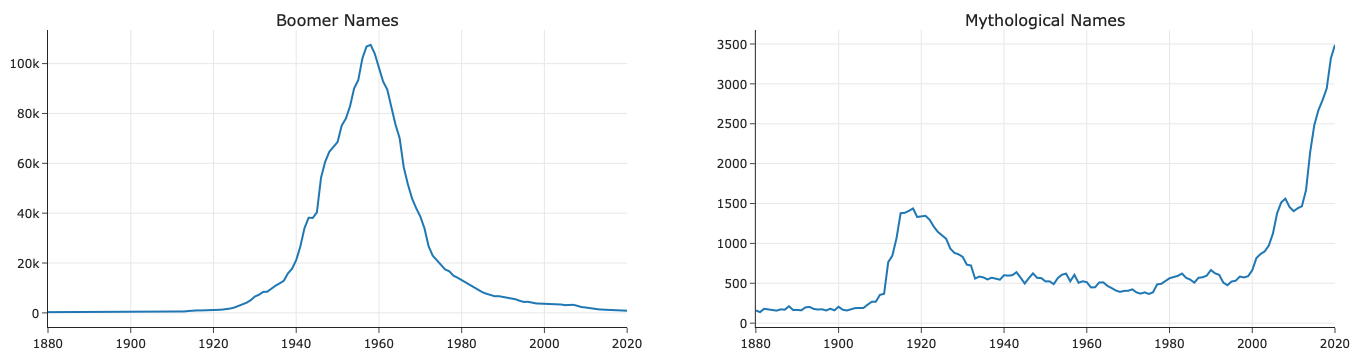

In [19]:
boomers = px.line(popular_name_change_over_time.query('category == "boomer"'),
                  x='Year', y='Count')
myths = px.line(popular_name_change_over_time.query('category == "mythology"'),
                x='Year', y='Count')

fig = left_right(boomers, myths, width=500, height=200,
                 subplot_titles=['Boomer Names', 'Mythological Names'])
margin(fig, t=30)
fig

As the NYT article claims, "baby boomer" names have become less popular after 2000, while mythological names have become more popular.

We can also plot the popularities of all the categories at once. Take a look at the plots below and see whether they support the claims made in the New York Times article.

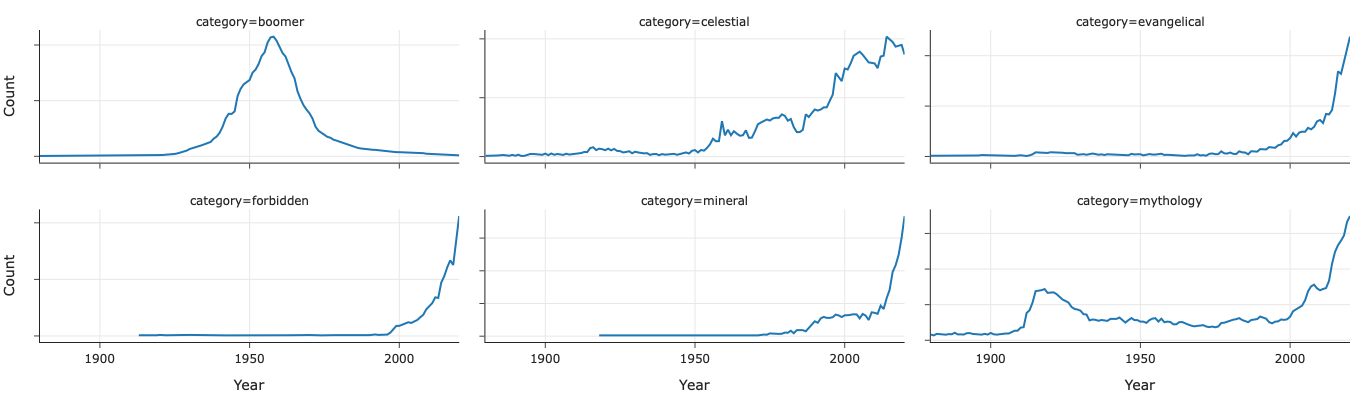

In [20]:
fig = px.line(popular_name_change_over_time, x='Year', y='Count',
              facet_col='category', facet_col_wrap=3,
              facet_row_spacing=0.15,
              width=600, height=400)
margin(fig, t=30)
fig.update_yaxes(matches=None, showticklabels=False)

## Takeaways

When joining dataframes together, we match rows using the `.merge()` function.
It's important to consider the type of join (inner, left, right, or outer)
when joining dataframes.
In the next section, we'll explain how to transform values in a dataframe.